In [150]:
"""Calculate results of comparing Kinect and Zeno gait metrics."""

import os

import pandas as pd
from scipy.stats import spearmanr, pearsonr

import sys
sys.path.append(os.path.join('..', '..'))

import analysis.stats as st


results_dir = os.path.join('..', '..', 'data', 'results')
match_dir = os.path.join('..', '..', 'data', 'matching')

df_k_raw = pd.read_csv(
    os.path.join(results_dir, 'kinect_gait_metrics.csv'), index_col=0)

df_z_raw = pd.read_csv(
    os.path.join(results_dir, 'zeno_gait_metrics.csv'), index_col=0)

df_match = pd.read_csv(os.path.join(match_dir, 'match_kinect_zeno.csv'))

# Drop rows where file has no match
df_match = df_match.dropna(axis=0)

df_match_zeno = pd.merge(df_match, df_z_raw, left_on='Zeno', right_index=True)

df_total = pd.merge(
    df_match_zeno,
    df_k_raw,
    left_on='Kinect',
    right_index=True,
    suffixes=('_z', '_k'))

# Take columns from total DataFrame to get Kinect and Zeno data
df_k = df_total.filter(like='_k')
df_z = df_total.filter(like='_z')

# Remove suffixes from column names
df_k = df_k.rename(columns=lambda x: str(x)[:-2])
df_z = df_z.rename(columns=lambda x: str(x)[:-2])

# Group by gait metric without suffix
df_k_grouped = df_k.groupby(
    lambda col_name: col_name[:-2],
    axis=1).apply(lambda x: pd.Series(x.values.flatten('F')))

df_z_grouped = df_z.groupby(
    lambda col_name: col_name[:-2],
    axis=1).apply(lambda x: pd.Series(x.values.flatten('F')))

# Calculate results
funcs = {
    'pearson':
    lambda a, b: pearsonr(a, b)[0],
    'spearman':
    lambda a, b: spearmanr(a, b)[0],
    'abs_rel_error':
    lambda a, b: st.relative_error(a, b, absolute=True).mean(),
    'bias':
    lambda a, b: st.bland_altman(a, b).bias,
    'range':
    lambda a, b: st.bland_altman(a, b).range_,
}

df_results_LR = st.compare_measurements(df_k, df_z, funcs)
df_results_grouped = st.compare_measurements(df_k_grouped, df_z_grouped, funcs)

## Plotting

In [107]:
import numpy as np

import analysis.math_funcs as mf
import matplotlib.pyplot as plt
import analysis.plotting as pl


In [108]:
from analysis.stats import relative_difference

In [109]:
plt.rc('text', usetex=True)

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 14,
       }

plt.rc('font', **font)  # pass in the font dict as kwargs

In [128]:
x_new = abs(df_k_grouped.stride_width)
x_valid = abs(df_z_grouped.stride_width)

In [129]:
differences = x_new - x_valid
means = (x_new + x_valid) / 2

rel_diffs = differences / means

bias, standard_dev = rel_diffs.mean(), rel_diffs.std()

lower_limit, upper_limit = mf.limits(bias, 1.96 * standard_dev)

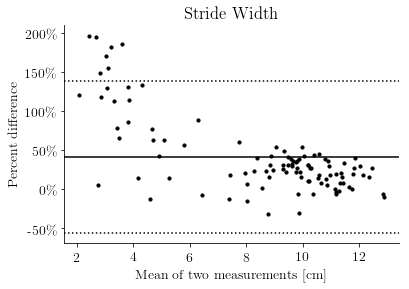

In [158]:
ax = plt.subplot(111)

ax.scatter(means, rel_diffs, c='k', s=10)

# Remove right and top borders
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Horizontal lines for bias and limits of agreement
ax.axhline(y=bias, color='k', linestyle='-')
ax.axhline(y=lower_limit, color='k', linestyle=':')
ax.axhline(y=upper_limit, color='k', linestyle=':')

# Format y labels as percentages
ax.set_yticklabels(['{:.0f}\%'.format(x*100) for x in ax.get_yticks()])

plt.xlabel('Mean of two measurements [cm]')
plt.ylabel('Percent difference')
plt.title('Stride Width')

plt.show()

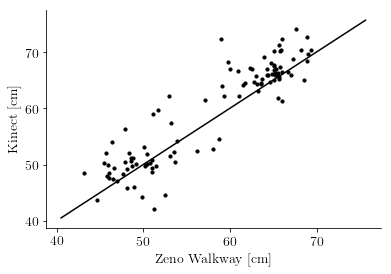

In [165]:
x_label, y_label = 'Zeno Walkway', 'Kinect'
param = 'step_length'
    
pl.compare_measurements(df_z_grouped[param], df_k_grouped[param], c='k', s=10)

# Remove right and top borders
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlabel("Zeno Walkway [cm]")
plt.ylabel("Kinect [cm]")
plt.show()